In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier

Loading Data into x_train and y_train

# XGBoost with 6 parameters with Depth selected on Cross-Validation

In [2]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


Display the shape of the data and additional details

## Checking if Sex is indeed a good Classifier

The titanic dataset assumes most women survived, while most men died. 
The next few lines of code confirms if this assumption stands True.

In [3]:
women = df.loc[df.Sex == 'female']['Survived']
print('% women survived', sum(women)/len(women))

% women survived 0.7420382165605095


In [4]:
men = df.loc[df.Sex == 'male']['Survived']
print('% men survived', sum(men)/len(men))

% men survived 0.18890814558058924



We see that about 75% of the women survived. And 18% of all men died.
So, we can conclude that Sex is indeed a good starting point.


## Defining Functions for Plotting Relationships between other Parameters and 'Survived' (output).

In [5]:
def hist(ax, prop, bins) :
    ax.hist(df[prop], bins)
    ax.hist(df.loc[df.Survived == 1][prop], bins=30)
    ax.set_ylabel('Count')
    ax.set_xlabel(prop)

def scatter(ax, prop) :
    data = {}
    for i in df[prop].unique() :
        pclass = df.loc[df[prop] == i]['Survived']
        if len(pclass) == 0 : continue
        data[i] = sum(pclass)/len(pclass) * 100
    data = dict(sorted(data.items(), key = lambda x : x[0]))
    ax.scatter(data.keys(), data.values())
    ax.set_ylabel('Percentage')
    ax.set_xlabel(prop)

def plot(ax, prop) :
    data = {}
    for i in df[prop].unique() :
        pclass = df.loc[df[prop] == i]['Survived']
        if len(pclass) == 0 : continue
        data[i] = sum(pclass)/len(pclass) * 100
    data = dict(sorted(data.items(), key = lambda x : x[0]))
    ax.plot(data.keys(), data.values())
    ax.set_ylabel('Percentage')
    ax.set_xlabel(prop)

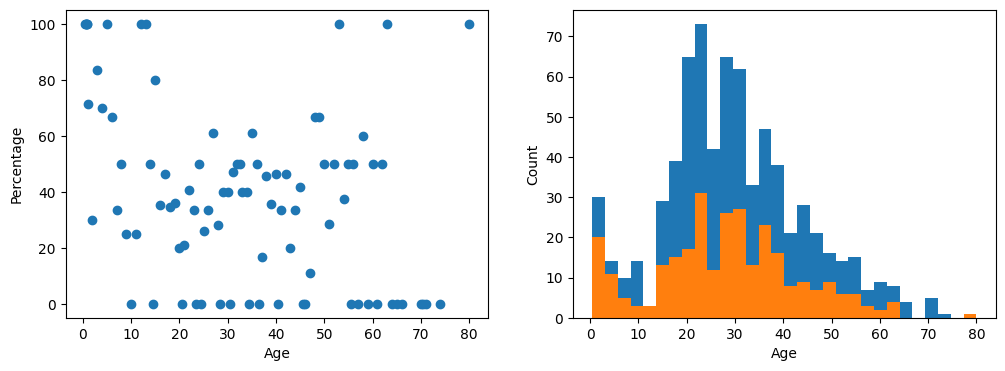

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4))
scatter(ax1, 'Age')
hist(ax2, 'Age', 30)

## One-Hot Encoding for Sex

In [7]:
df1 = df.copy()
df1 = df['Male'] = df1['Sex'].apply(lambda x : 1 if x == 'male' else 0)
df1 = df.drop('Sex', axis=1)
df1.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Male
0,1,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,3,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,1,0
4,5,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,0,1


## Check for other Paramters (Pclass, Sibling Spouse, Parch)

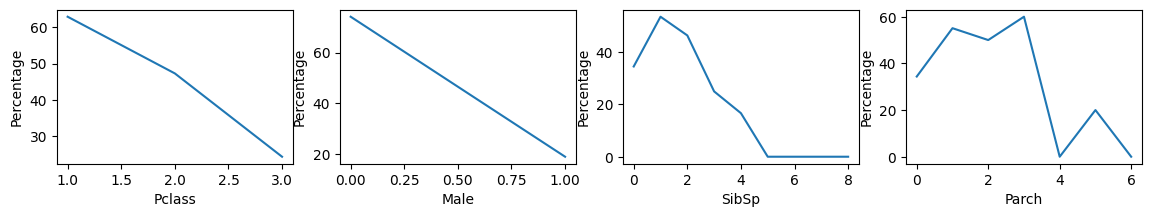

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (14,2))
plot(ax1, 'Pclass')
plot(ax2, 'Male')

# fig, (ax3, ax4) = plt.subplots(1,2, figsize = (8,4))
plot(ax3, 'SibSp')
plot(ax4, 'Parch')

## Preparing Test and Cross-Validation Datasets

In [9]:
features = ['Pclass', 'Male', 'SibSp', 'Parch', 'Age', 'Fare']

df_train = df1.iloc[:670]
df_cv = df1.iloc[670:]

x_train = df_train[features].to_numpy()
y_train = df_train['Survived'].to_numpy()

x_cv = df_cv[features].to_numpy()
y_cv = df_cv['Survived'].to_numpy()

print(x_train.shape, y_train.shape)
print(x_cv.shape, y_cv.shape)

(670, 6) (670,)
(221, 6) (221,)


## Plotting Accuracy vs. Depth for Training and Cross-Validation Datasets

In [10]:
def get_accuracy(model, x, y) :
    predictions = model.predict(x)
    m,n = x.shape
    res = 0
    for i in range(m) : 
         if (predictions[i] == y[i]) : res += 1
    return round(res/m, 4)

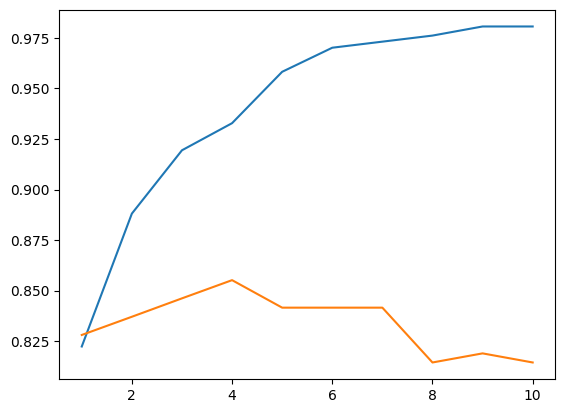

In [11]:
total_depth = 10
depth = list(range(1,total_depth+1))
train_accuracy = np.zeros(total_depth)
cv_accuracy = np.zeros(total_depth)

for i in depth :
    model = XGBClassifier(max_depth = i)
    model.fit(x_train, y_train)
    
    train_accuracy[i-1] = get_accuracy(model, x_train, y_train)
    cv_accuracy[i-1] = get_accuracy(model, x_cv, y_cv)

plt.plot(depth, train_accuracy)
plt.plot(depth, cv_accuracy)
plt.show()

We see that the CV dataset performs best on max-depth 4. So we select that depth for our model.

In [12]:
target_depth = np.argmax(cv_accuracy)+1

model = XGBClassifier(max_depth = target_depth)
model.fit(x_train, y_train)
print(f'Accuracy is {get_accuracy(model, x_cv, y_cv) * 100}%')

Accuracy is 85.52%


# Generating the output for the Test File

In [13]:
df_test = pd.read_csv('test.csv')
df_test['Male'] = df_test['Sex'].apply(lambda x : 1 if x == 'male' else 0)
# df_test.drop('Sex', axis = 1)
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Male
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


In [14]:
x_test = df_test[features].to_numpy()
test_predictions = model.predict(x_test)

In [15]:
women_i = x_test[:,1] == 1
women_pred = test_predictions[women_i]

print('Percentage of women who survived', sum(women_pred)/len(women_pred) * 100)

Percentage of women who survived 8.646616541353383


In [16]:
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': test_predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
